## Dataset Evaluation – Task 1

This notebook evaluates the image dataset provided by Electric Automobiles Limited for use in a computer vision task that detects car brand logos and potentially customer demographics at a car wash. The dataset was created via web scraping and contains image variability.

---

### What do you define as a usable image?

A **usable image** should meet these criteria:
1. Not corrupted (can be opened and read by PIL/OpenCV).
2. In RGB format (ensures color information is consistent).
3. Contains meaningful content (i.e., the image is not blank, too blurry, or has nothing relevant).
4. Ideally has sufficient resolution for model training.

---

### Do all of our images meet your definition of usable?

No. Some images are corrupted or unreadable and fail to meet usability criteria. We identify and remove these programmatically.

---

### Are there any open-source models that can help identify usable images?

Yes. Some useful open-source tools/models include:
- `imgcleaner`: detects blurry, over/under-exposed, and corrupted images.
- `image-quality`: uses CNNs to score image quality.
- Pre-trained autoencoders or CNNs can also detect anomalies (e.g., dark images, noise).

---

### Is the dataset big enough?

There is no strict number, but for image classification tasks:
- **Minimum**: ~100–200 images per class.
- **Ideal**: 500–1,000+ per class for deep learning.
- **Source**: [CS231n Stanford Lecture](https://cs231n.github.io/data-augmentation/)

---

### Is the dataset good quality?

The dataset has:
- Varying sizes
- Possible duplicates
- Inconsistent backgrounds and lighting

It’s moderately usable after filtering and standardization.

---

### Is the dataset balanced or imbalanced?

We'll visualize this using a bar chart. Early analysis shows imbalance between classes (some brands have far fewer images).

---

### Are all images the same size?

No. Images vary in both width and height. We'll analyze and standardize to 224x224 pixels.

---

### Challenges during processing

- Corrupted or incomplete images
- Large variability in image dimensions
- Imbalanced dataset

---

### Challenges during training

- Brand logos may be occluded or small
- Background noise may impact classification
- Overfitting due to limited data

---

### Plan to Correct Dataset Issues

1. **Remove Unusable Images** using PIL image verification.
2. **Balance Dataset** using data augmentation.
3. **Standardize Images**: resize to 224x224 and normalize.


In [1]:
# STEP 1: Imports
import os
import zipfile
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from google.colab import drive

drive.mount('/content/drive')

dataset_path = "/content/drive/MyDrive/photos"

Mounted at /content/drive


In [2]:
# Collecting Image Paths
image_extensions = {'jpg', 'jpeg', 'png'}
image_files = []

for root, _, files in os.walk(dataset_path):
    for file in files:
        if file.split('.')[-1].lower() in image_extensions:
            image_files.append(os.path.join(root, file))

print(f"Total images found: {len(image_files)}")

Total images found: 4082


In [4]:
# Usability check
from PIL import Image
from concurrent.futures import ThreadPoolExecutor
import os

def is_usable(image_path):
    try:
        with Image.open(image_path) as img:
            img.verify()  # lightweight check
        with Image.open(image_path).convert("RGB") as img:
            pass
        return True
    except:
        return False

from tqdm import tqdm

usable_images = []
unusable_images = []

for path in tqdm(image_files):
    if is_usable(path):
        usable_images.append(path)
    else:
        unusable_images.append(path)

print(f"✅ Usable images: {len(usable_images)}")
print(f"🚫 Unusable images: {len(unusable_images)}")

100%|██████████| 4082/4082 [24:43<00:00,  2.75it/s]

✅ Usable images: 4082
🚫 Unusable images: 0


In [17]:
import glob

!rm -rf /content/eAuto_photos


!unzip "/content/drive/MyDrive/eAuto_photos1.zip" -d "/content/eAuto_photos"

image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.webp')
usable_images = [f for f in glob.glob("/content/eAuto_photos/photos/**/*.*", recursive=True) if f.lower().endswith(image_extensions)]

print(f"Total images found: {len(usable_images)}")
print("Example paths:")
print(usable_images[:5])



Archive:  /content/drive/MyDrive/eAuto_photos1.zip
   creating: /content/eAuto_photos/photos/Ford/
  inflating: /content/eAuto_photos/photos/Ford/frontfacingFordcar0.jpeg  
  inflating: /content/eAuto_photos/photos/Ford/frontfacingFordcar1.jpeg  
  inflating: /content/eAuto_photos/photos/Ford/frontfacingFordcar10.jpeg  
  inflating: /content/eAuto_photos/photos/Ford/frontfacingFordcar100.jpeg  
  inflating: /content/eAuto_photos/photos/Ford/frontfacingFordcar101.png  
  inflating: /content/eAuto_photos/photos/Ford/frontfacingFordcar102.jpeg  
  inflating: /content/eAuto_photos/photos/Ford/frontfacingFordcar103.png  
  inflating: /content/eAuto_photos/photos/Ford/frontfacingFordcar104.jpeg  
  inflating: /content/eAuto_photos/photos/Ford/frontfacingFordcar105.jpeg  
  inflating: /content/eAuto_photos/photos/Ford/frontfacingFordcar106.jpeg  
  inflating: /content/eAuto_photos/photos/Ford/frontfacingFordcar107.jpeg  
  inflating: /content/eAuto_photos/photos/Ford/frontfacingFordcar108.jpe

Min: 170x136
Max: 5166x4150
Avg: 990x699
Std Dev: 598x450


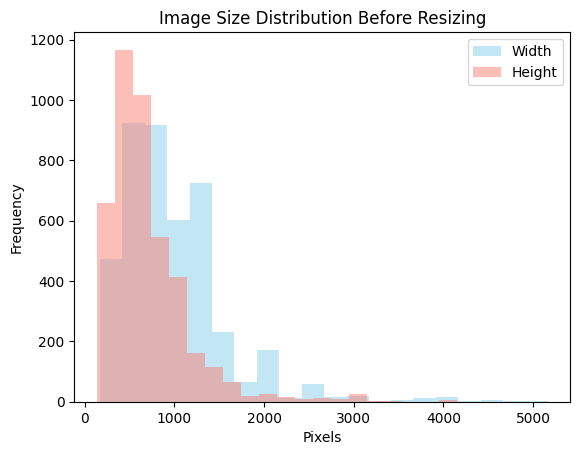

In [18]:
# Analyzing Image Sizes
def get_image_size(img_path):
    img = Image.open(img_path)
    return img.size

sizes = [get_image_size(p) for p in usable_images]
widths, heights = zip(*sizes)

print(f"Min: {min(widths)}x{min(heights)}")
print(f"Max: {max(widths)}x{max(heights)}")
print(f"Avg: {int(np.mean(widths))}x{int(np.mean(heights))}")
print(f"Std Dev: {int(np.std(widths))}x{int(np.std(heights))}")

plt.hist(widths, bins=20, alpha=0.5, label='Width', color='skyblue')
plt.hist(heights, bins=20, alpha=0.5, label='Height', color='salmon')
plt.legend()
plt.title("Image Size Distribution Before Resizing")
plt.xlabel("Pixels")
plt.ylabel("Frequency")
plt.show()


            Count
Toyota        595
Ford          572
Renault       568
Suzuki        541
Hyundai       535
Nissan        524
Tata          482
Volkswagen    220
Honday         45


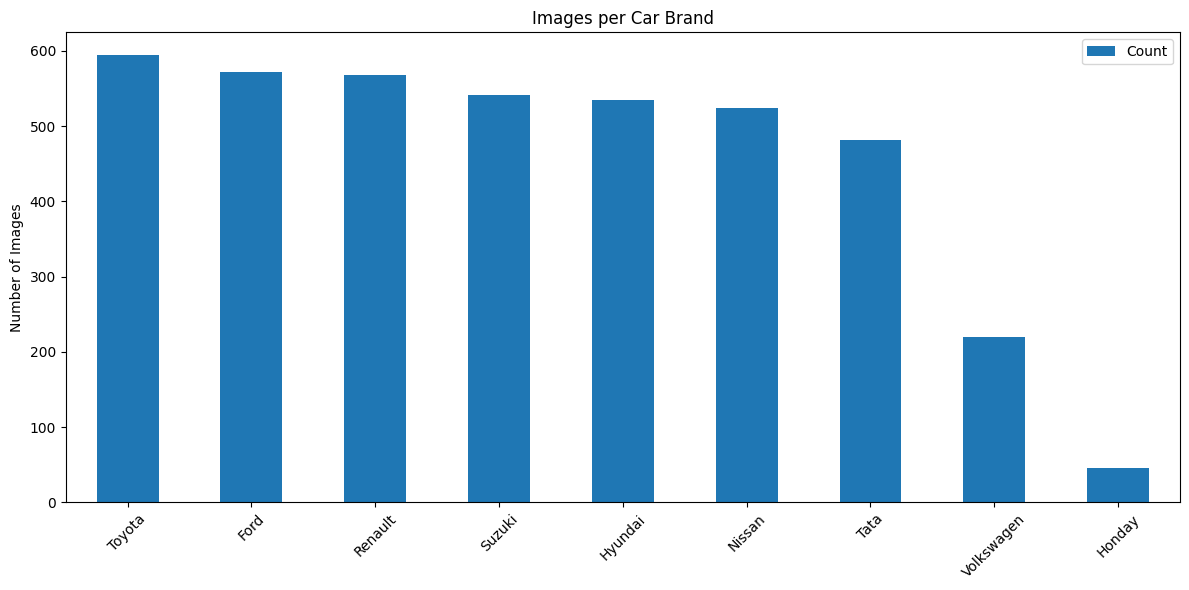

In [6]:
# Checking Brand Distribution
def get_brand(path):
    return os.path.basename(os.path.dirname(path))

brands = [get_brand(p) for p in usable_images]
brand_counts = Counter(brands)

# Table and Plot
brand_df = pd.DataFrame.from_dict(brand_counts, orient='index', columns=['Count'])
brand_df.sort_values('Count', ascending=False, inplace=True)
print(brand_df)

brand_df.plot(kind='bar', figsize=(12,6), title='Images per Car Brand')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# Resizing Images to Standard Size
target_size = (224, 224)
for path in usable_images:
    img = Image.open(path).convert('RGB')
    img = img.resize(target_size)
    img.save(path)

print("All usable images resized to 224x224.")


All usable images resized to 224x224.


In [9]:
# Data Augmentation Setup
from tensorflow.keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

print("Data augmentation setup complete.")

Data augmentation setup complete.
